In [ ]:
!git clone https://github.com/ml-repro-team-2/re-rosetta.git

In [1]:
cd /kaggle/working/re-rosetta

/kaggle/working/re-rosetta


In [ ]:
!git checkout anant

In [ ]:
#@title Requirements
!pip install -r requirements.txt
!pip install transformers
!pip install openai-clip
!pip install einops
!pip install pytorch_pretrained_biggan
!pip install Ninja
!pip install timm==0.4.12
!pip install dill

In [2]:
import os
import sys
current = os.path.dirname(os.path.realpath("single_neuron_edit.ipynb"))
parent = os.path.dirname(current)
sys.path.append(parent)
import copy
from time import perf_counter
import dill
import click
import imageio
import numpy as np
import PIL.Image
import torch
import torch.nn.functional as F
import os.path
from tqdm import trange
import dnnlib
import styleganxl.legacy
from styleganxl import metric_utils
import timm
import timm.models.vision_transformer
from styleganxl.diffaug import DiffAugment
from pg_modules.blocks import Interpolate
from transformers import CLIPProcessor, CLIPModel
from torchvision.models import resnet50
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import clip
from PIL import Image
import requests
import time
import pickle
import math
import tensorflow
from mae import load_mae
from match_utils import matching, stats, nethook, dataset, loading, plotting, layers, universal, models

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Loads models, tables, matches

In [3]:
num_steps=500
lr_rampdown_length = 0.25
lr_rampup_length = 0.05
initial_learning_rate = 0.001
classs = 916

device = 'cuda:0'
device = torch.device(device)

discr_mode = 'clip'
discr, _ = clip.load("RN50", device=device)
discr_layers = [ "visual.layer1", "visual.layer2", "visual.layer3", "visual.layer4"]
for p in discr.parameters():
    p.data = p.data.float()

# Load GAN.
G, gan_layers = models.load_gan('styleganxl', device=device)
ganlayers, discrlayers = layers.get_layers(G,gan_layers, discr, discr_layers,"styleganxl", discr_mode, device)

G = nethook.InstrumentedModel(G)
G.retain_layers(gan_layers, detach = False)

discr = nethook.InstrumentedModel(discr)
discr.retain_layers(discr_layers)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


In [4]:
perfect_matches = []
discr_perfect_matches = []
universal_matches, stats = universal.get_universal_activations("/kaggle/input/stylegan-xl128-916/rosetta_neurons/matches/styleganxl/clip/916",
                          "/kaggle/input/stylegan-xl128-916/rosetta_neurons/matches/styleganxl/dino/916",
                          "/kaggle/input/stylegan-xl128-916/rosetta_neurons/matches/styleganxl/dino_vitb16/916", 
                          "/kaggle/input/stylegan-xl128-916/rosetta_neurons/matches/styleganxl/mae/916",
                          "/kaggle/input/stylegan-xl128-916/rosetta_neurons/matches/styleganxl/resnet50/916",
                           device = device, n = 10)
for i, j in universal_matches.items():
    perfect_matches.append(i)
    discr_perfect_matches.append(j[-1])

for i, unit in enumerate(perfect_matches):
    perfect_matches[i] = layers.find_act(perfect_matches[i], ganlayers)

Loading...
Done
Loading...
Done
Loading...
Done
Loading...
Done
Loading...
Done


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [17]:
z_sample_count = 1

z_samples = torch.from_numpy(np.random.randn(z_sample_count, G.model.z_dim)).to(device)
c_samples = np.zeros([z_sample_count, G.model.c_dim], dtype=np.float32)
c_samples[:, classs] = 1
c_samples = torch.from_numpy(c_samples).to(device)

w_samples = G.model.mapping(z_samples, c_samples)  # [N, L, C]
print(w_samples.shape)
# get empirical w_avg

w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)       # [N, 1, C]
w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 1, C]

torch.Size([1, 27, 512])


In [18]:
w_src = torch.tensor(copy.deepcopy(w_avg), dtype=torch.float32, device=device, requires_grad=False).to(device)
w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True).to(device) # pylint: disable=not-callable
optimizer = torch.optim.Adam([w_opt], betas=(0.9, 0.999), lr=initial_learning_rate)

In [19]:
# w_opt[0]

In [20]:
# w_opt[0].repeat(1,G.model.num_ws,1).shape

In [21]:
# init = G.model.synthesis(w_opt[0].repeat(1,G.model.num_ws,1), noise_mode='const')
# init.shape

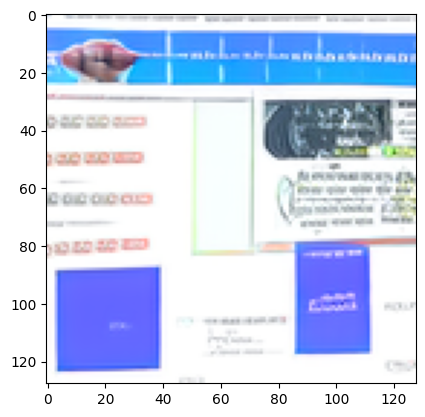

In [22]:
init = G.model.synthesis(w_opt[0].repeat(1,G.model.num_ws,1), noise_mode='const')
init = (init.detach().cpu()+1)/2
init = torch.permute(init[0], (1,2,0))
plt.imshow(init)
init = (init-torch.min(init))/(torch.max(init)-torch.min(init))
init = np.uint8(init*255)

In [23]:
_,gan_stats, discr_stats = loading.load_stats("/kaggle/input/stylegan-xl128-916/rosetta_neurons/matches/styleganxl/clip/916", device=device)

Loading...
Done


In [24]:
gan_activs = matching.store_activs(G, gan_layers)

eps = 0.00001
for i,_ in enumerate(gan_activs):
    gan_activs[i] = (gan_activs[i]-gan_stats[i][0])/(gan_stats[i][1]+eps)
    
gan_perfect_activs = []
for idx in perfect_matches:
    gan_perfect_activs.append(gan_activs[idx[0]][:,idx[1],:,:])


In [25]:
import matplotlib.pyplot as plt

In [26]:
len(gan_perfect_activs)

58

In [ ]:
# for i in gan_perfect_activs:
ncols = 10
nrows = len(gan_perfect_activs)//ncols
fig, axes = plt.subplots(nrows,ncols,figsize=(20,20))
for i,row_axes in enumerate(axes):
    for j,axis in enumerate(row_axes):
        axis.imshow(gan_perfect_activs[ncols*i+j].squeeze().cpu().detach().double())
        axis.set_axis_off()
#         axis.set_label(f"{i*ncols+j}")
        axis.set_title(f"{i * ncols + j}") 

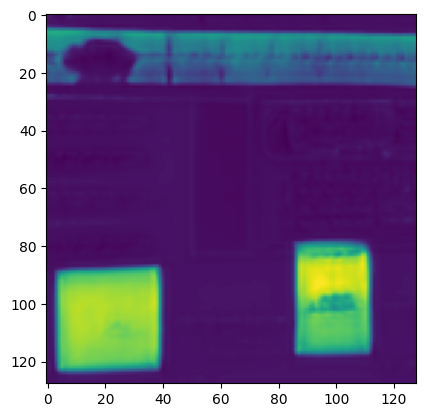

In [29]:
init = gan_perfect_activs[0]
plt.imshow(init[0].squeeze().cpu().detach().double())

In [31]:
maxx = torch.max(init)

torch.Size([1, 128, 128])


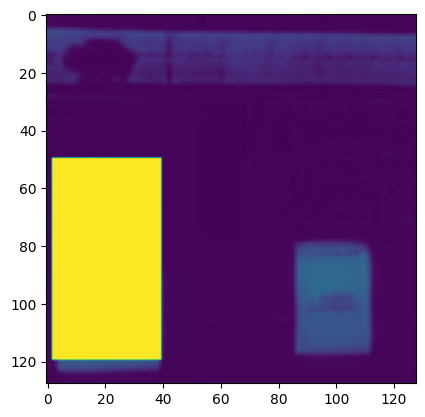

In [33]:
ref = init.clone()
print(ref.shape)
ref[0,50:120,2:40] = 3*maxx
plt.imshow(ref[0].detach().cpu())
ref = ref.unsqueeze(0).detach()

In [ ]:
# ref = init.clone()
# ref[0,60:80, 60:70] = 3*maxx
# plt.imshow(ref[0].detach().cpu())
# ref = ref.unsqueeze(0).detach()

-0.5403002586327936
[ step    1/500] 


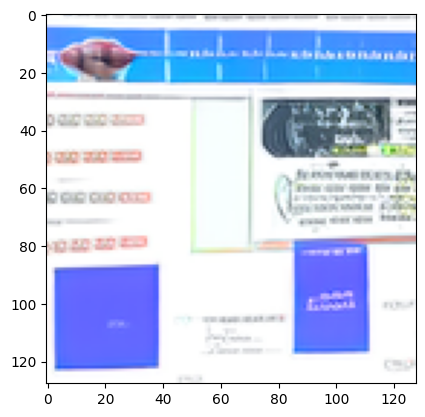

-0.5403002586327936
[ step    2/500] 
-0.5404035743812642
[ step    3/500] 
-0.5405877556165576
[ step    4/500] 
-0.5408066167404462
[ step    5/500] 
-0.5411229840172115
[ step    6/500] 
-0.5414565088111208
[ step    7/500] 
-0.5418941787124961
[ step    8/500] 
-0.5423577817717627
[ step    9/500] 
-0.542826608077807
[ step   10/500] 
-0.5434133470385967
[ step   11/500] 
-0.543972125876468
[ step   12/500] 
-0.5445590605195931
[ step   13/500] 
-0.5451745122513398
[ step   14/500] 
-0.5458326155859502
[ step   15/500] 
-0.546508683034297
[ step   16/500] 
-0.5471792278556987
[ step   17/500] 
-0.5478824375779632
[ step   18/500] 
-0.5485831098788646
[ step   19/500] 
-0.5492415033788806
[ step   20/500] 
-0.549893631174154
[ step   21/500] 
-0.5506194054303305
[ step   22/500] 
-0.5512546963109584
[ step   23/500] 
-0.5519340718134275
[ step   24/500] 
-0.5526353548181305
[ step   25/500] 
-0.5534721174449445
[ step   26/500] 
-0.5543761096592704
[ step   27/500] 
-0.5551093027514

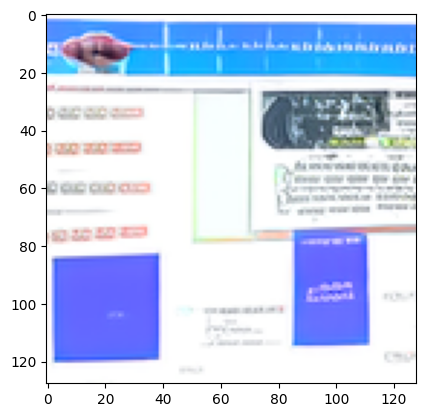

-0.5710632591545937
[ step   52/500] 
-0.5716825882651863
[ step   53/500] 
-0.5722488828823178
[ step   54/500] 
-0.5728837049976133
[ step   55/500] 
-0.5734941397597599
[ step   56/500] 
-0.5741277341109564
[ step   57/500] 
-0.5747365790066479
[ step   58/500] 
-0.5753154560111509
[ step   59/500] 
-0.5759290964582773
[ step   60/500] 
-0.5765073627780466
[ step   61/500] 
-0.5772008194096959
[ step   62/500] 
-0.5777863003148088
[ step   63/500] 
-0.5783864148637776
[ step   64/500] 
-0.5789544959214185
[ step   65/500] 
-0.5795592405607317
[ step   66/500] 
-0.5801626601115542
[ step   67/500] 
-0.5807570831856379
[ step   68/500] 
-0.5812779747795547
[ step   69/500] 
-0.5818827574330424
[ step   70/500] 
-0.5825419636401624
[ step   71/500] 
-0.5830974492405038
[ step   72/500] 
-0.5837065989754027
[ step   73/500] 
-0.5842806995445904
[ step   74/500] 
-0.5848772578774342
[ step   75/500] 
-0.5855027256913015
[ step   76/500] 
-0.5860417756194434
[ step   77/500] 
-0.586646152

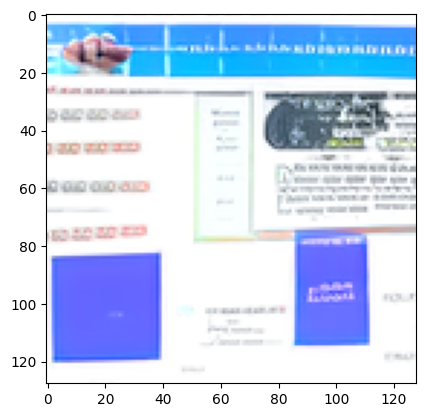

-0.6001013603945468
[ step  102/500] 
-0.6006353368217042
[ step  103/500] 
-0.6011960427418975
[ step  104/500] 
-0.6016863605669588
[ step  105/500] 
-0.6022363643113318
[ step  106/500] 
-0.602816513646516
[ step  107/500] 
-0.603338769262083
[ step  108/500] 
-0.6038127798410532
[ step  109/500] 
-0.6044088674112497
[ step  110/500] 
-0.6049553715659602
[ step  111/500] 
-0.6054701154694068
[ step  112/500] 
-0.6060093503576646
[ step  113/500] 
-0.6065983961135288
[ step  114/500] 
-0.607094430887304
[ step  115/500] 
-0.6075775950341071
[ step  116/500] 
-0.608136023141681
[ step  117/500] 
-0.6086337894075396
[ step  118/500] 
-0.6090805380071663
[ step  119/500] 
-0.6096229648568559
[ step  120/500] 
-0.610220253916401
[ step  121/500] 
-0.6107249132032407
[ step  122/500] 
-0.6112624676479461
[ step  123/500] 
-0.6118168258401698
[ step  124/500] 
-0.6123234498593185
[ step  125/500] 
-0.6128570371759661
[ step  126/500] 
-0.6133733600768688
[ step  127/500] 
-0.61387508137394

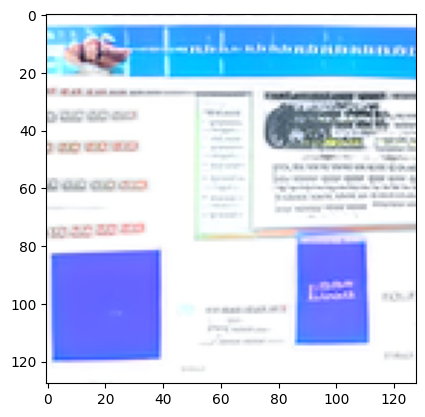

-0.6268938619127677
[ step  152/500] 
-0.6274620551270577
[ step  153/500] 
-0.6279882089432508
[ step  154/500] 
-0.6285798329252715
[ step  155/500] 
-0.6291878793524497
[ step  156/500] 
-0.6296853687538326
[ step  157/500] 
-0.6302854200482807
[ step  158/500] 
-0.6308711805832438
[ step  159/500] 
-0.631499774987772
[ step  160/500] 
-0.6320571127417651
[ step  161/500] 
-0.6326463537869164
[ step  162/500] 
-0.6332075489519414
[ step  163/500] 
-0.6338275270955516
[ step  164/500] 
-0.6344914819871271
[ step  165/500] 
-0.6350438754803716
[ step  166/500] 
-0.6356420857917967
[ step  167/500] 
-0.6362986882776362
[ step  168/500] 
-0.6368403708174465
[ step  169/500] 
-0.6374579330058542
[ step  170/500] 
-0.6380863047415125
[ step  171/500] 
-0.6387170306654135
[ step  172/500] 
-0.6392495351998956
[ step  173/500] 
-0.6398775047053895
[ step  174/500] 
-0.6405137219322693
[ step  175/500] 
-0.6411363699875152
[ step  176/500] 
-0.6416858073143173
[ step  177/500] 
-0.6423591999

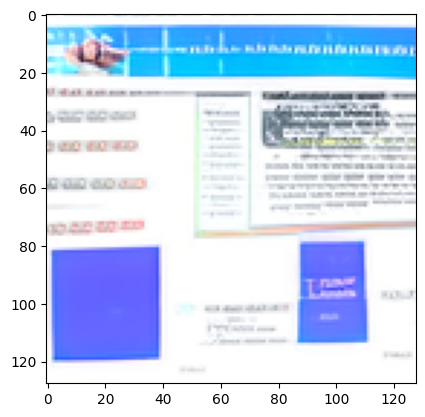

-0.6577971049529763
[ step  202/500] 
-0.6584926327464892
[ step  203/500] 
-0.6591064652899502
[ step  204/500] 
-0.6598520336650106
[ step  205/500] 
-0.6605038801543252
[ step  206/500] 
-0.6611658903540555
[ step  207/500] 
-0.6619025183993423
[ step  208/500] 
-0.662528097707052
[ step  209/500] 
-0.663254010058206
[ step  210/500] 
-0.663975315583689
[ step  211/500] 
-0.6646475027323288
[ step  212/500] 
-0.6653907240239662
[ step  213/500] 
-0.666089462377537
[ step  214/500] 
-0.6667951196581925
[ step  215/500] 
-0.6675429481388715
[ step  216/500] 
-0.668268483236696
[ step  217/500] 
-0.6689856191180339
[ step  218/500] 
-0.669678188669393
[ step  219/500] 
-0.6704078471362996
[ step  220/500] 
-0.6711139184463565
[ step  221/500] 
-0.6718585880981471
[ step  222/500] 
-0.6725427744837863
[ step  223/500] 
-0.6732711926220064
[ step  224/500] 
-0.6739878871819175
[ step  225/500] 
-0.674773037603214
[ step  226/500] 
-0.675477739964782
[ step  227/500] 
-0.6761728617823239


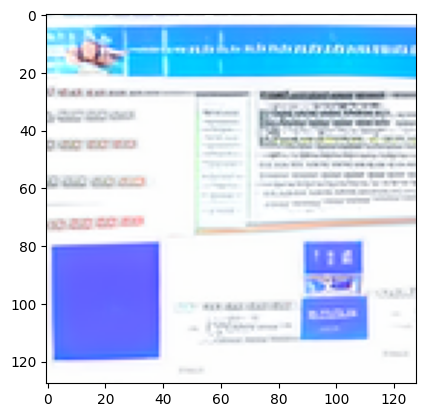

-0.6905407590374036
[ step  252/500] 
-0.6910480765282399
[ step  253/500] 
-0.6915380531387053
[ step  254/500] 
-0.6920608691648866
[ step  255/500] 
-0.6925423773315572
[ step  256/500] 
-0.6930312464097598
[ step  257/500] 
-0.6935618985061671
[ step  258/500] 
-0.6940270115815376
[ step  259/500] 
-0.6945110069758864
[ step  260/500] 
-0.694994004356539
[ step  261/500] 
-0.6954693866049863
[ step  262/500] 
-0.6959383166526579
[ step  263/500] 
-0.6963824899343759
[ step  264/500] 
-0.6968890612629598
[ step  265/500] 
-0.6973582886748642
[ step  266/500] 
-0.6978210772663277
[ step  267/500] 
-0.6983080612267496
[ step  268/500] 
-0.6987445777620543
[ step  269/500] 
-0.6992417526626808
[ step  270/500] 
-0.6997308862454762
[ step  271/500] 
-0.7001971479351314
[ step  272/500] 
-0.7006375193601297
[ step  273/500] 
-0.7010955498135395
[ step  274/500] 
-0.7015291729844401
[ step  275/500] 
-0.702014593823276
[ step  276/500] 
-0.7024599401991001
[ step  277/500] 
-0.70292113117

KeyboardInterrupt: 

In [36]:
all_images = []
for step in range(num_steps):
    # Learning rate schedule.
    t = step / num_steps
    lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
    lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
    lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
    lr = initial_learning_rate * lr_ramp
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    # Synth images from z
    synth_images = G.model.synthesis(w_opt[0].repeat(1,G.model.num_ws,1), noise_mode='const')


    # track images
    synth_images = (synth_images + 1) * (255/2)
    synth_images_np = synth_images.clone().detach().permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    all_images.append(synth_images_np)

    # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
    if synth_images.shape[2] > 256:
        synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')


    gan_activs = matching.store_activs(G, gan_layers)

    #normalize all activations
    eps = 0.00001
    for i,_ in enumerate(gan_activs):
        gan_activs[i] = (gan_activs[i]-gan_stats[i][0])/(gan_stats[i][1]+eps)

    gan_perfect_activs = []
    for idx in perfect_matches:
        gan_perfect_activs.append(gan_activs[idx[0]][:,idx[1],:,:])



    #pearson correlation
    a_loss = 0

    ### index into activation we are editing
    i = 0
    map_size = gan_perfect_activs[i]
    gan_activ_new = gan_perfect_activs[i].unsqueeze(0)
    prod = torch.einsum('aixy,ajxy->ij', gan_activ_new, ref)
    div1 = torch.sum(gan_activ_new**2)
    div2 = torch.sum(ref**2)
    corr = prod/torch.sqrt(div1*div2)
    a_loss += corr


    a_loss *= -1
    l_reg = torch.mean((w_src - w_opt)**2)
    loss = a_loss + 0 * l_reg

    # Step
    optimizer.zero_grad(set_to_none=True)

    loss.backward()
    optimizer.step()
    msg  = f'[ step {step+1:>4d}/{num_steps}] '
    print(a_loss.item())
    #msg += f'[ a_loss: {float(a_loss):5.2f} loss_reg: {0.1 * float(l_reg):5.2f}] '
    print(msg)
    if step % 50 == 0:
        plt.imshow(synth_images_np)
        plt.show()


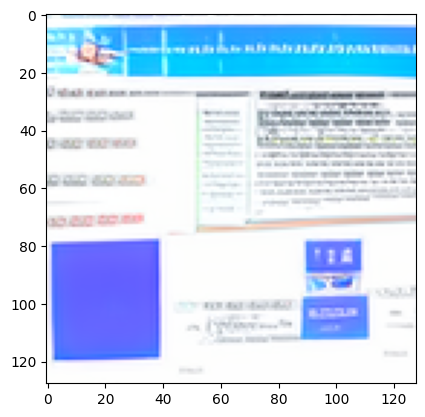

In [37]:
final = G.model.synthesis(w_opt[0].repeat(1,G.model.num_ws,1), noise_mode='const')
#final, _ = G([z], 0.7, mean_latent)
final = (final.detach().cpu()+1)/2
final = torch.permute(final[0], (1,2,0))
plt.imshow(final)